![](https://miro.medium.com/max/700/1*HgXA9v1EsqlrRDaC_iORhQ.png)

## Importing Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Sat Mar 13 13:11:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
!pip install kaggle

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers #huggingface transformers library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

## Configuration for TPUs

The given news classifier is trained on using BERT model. Since, BERT is a very large model, it requires gpu's and tpu's to train quickly. Here, I have used TPU's provided by Kaggle to train this model.

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
!cp /content/drive/MyDrive/kaggle.json /content/

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Check the file in its new directory
!ls /root/.kaggle/

# Check the file permission
!ls -l ~/.kaggle/kaggle.json

#Change the file permission
# chmod 600 file – owner can read and write
# chmod 700 file – owner can read, write and execute
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json
-rw------- 1 root root 67 Mar 13 13:11 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d rmisra/news-category-dataset

 63% 16.0M/25.4M [00:00<00:00, 37.1MB/s]
100% 25.4M/25.4M [00:00<00:00, 73.1MB/s]


In [ ]:
!unzip /content/news-category-dataset.zip

Archive:  /content/news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


## Preprocessing

In [ ]:
df = pd.read_json('/content/News_Category_Dataset_v2.json', lines = True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
# WORLDPOST and THE WORLDPOST were given as two separate categories in the dataset. Here I change the category THE WORLDPOST to WORLDPOST 
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [ ]:
print(f"The dataset contains { df.category.nunique() } unique categories")

The dataset contains 40 unique categories


In [ ]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

In [ ]:
#since I am using bert-large-uncased as the model, I am converting each of the news headlines and descriptions into lower case.
df['headline'] = df['headline'].apply(lambda headline: str(headline).lower())
df['short_description'] = df['short_description'].apply(lambda descr: str(descr).lower())

In [ ]:
#calculating the length of headlines and descriptions
df['descr_len'] = df['short_description'].apply(lambda x: len(str(x).split()))
df['headline_len'] = df['headline'].apply(lambda x: len(str(x).split()))

In [ ]:
df.describe()

,categoryEncoded,descr_len,headline_len
count,200853.000000,200853.000000,200853.000000
mean,22.024366,19.728289,9.538563
std,10.753991,14.409189,3.089320
min,0.000000,0.000000,0.000000
25%,13.000000,10.000000,7.000000
50%,24.000000,19.000000,10.000000
75%,30.000000,24.000000,12.000000
max,39.000000,243.000000,44.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


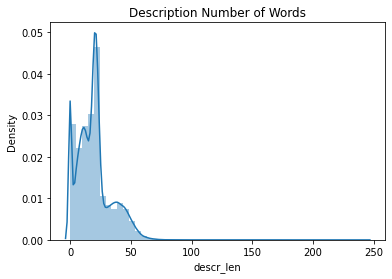

In [ ]:
sns.distplot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


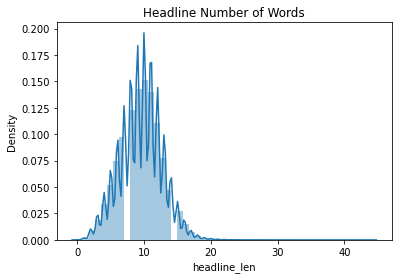

In [ ]:
sns.distplot(df['headline_len'])
plt.title('Headline Number of Words')
plt.show()

As we can see, that there are a lot of samples that have a description length of 0, however almost all articles have a headline. Going with the intuition that the headline is often more descriptive of the category of the news, as well as to provide more text data to the model, I add news headlines to the short description and modify the description of the news samples.

In [ ]:
df['short_description'] = df['headline'] + df['short_description']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


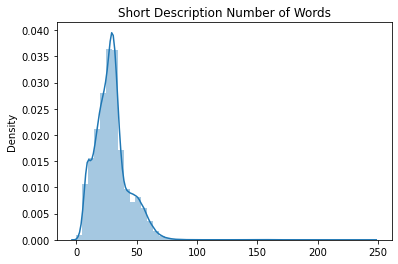

In [ ]:
sns.distplot(df['headline_len'] + df['descr_len'])
plt.title('Short Description Number of Words')
plt.show()

## Tokenizing

* I use the HuggingFace tokenizer for bert to tokenize the given news descriptions. After splitting up the dataset into train and test, we encode both the training data and the testing data. 
* One more thing to notice is that we truncate the last part of the sentence when encoding it, thus adding the headlines to the front of the description means that our model will always have the headline of the news sample.

In [ ]:
# def regular_encode(texts, tokenizer, maxlen=512):
#     enc_di = tokenizer.batch_encode_plus(
#         texts, 
#         return_token_type_ids=False,
#         padding='max_length',
#         max_length=maxlen
#     )
    
#     return np.array(enc_di['input_ids'])

In [ ]:
#bert large uncased pretrained tokenizer
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
X_train,X_test ,y_train,y_test = train_test_split(df['short_description'].to_list(),
                                                  df['categoryEncoded'].to_list(), random_state = 2020, 
                                                  test_size = 0.3,
                                                  stratify=df['categoryEncoded'].to_list())

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding='max_length',max_length=512, return_tensors='tf')
test_encodings = tokenizer(X_test, truncation=True, padding='max_length',max_length=512, return_tensors='tf',)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=40,dtype = 'float32')
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=40,dtype = 'float32')

In [ ]:
train_encodings

{'input_ids': <tf.Tensor: shape=(140597, 512), dtype=int32, numpy=
array([[  101,  3782,  6508, ...,     0,     0,     0],
       [  101,  2054,  2024, ...,     0,     0,     0],
       [  101, 24794,  3501, ...,     0,     0,     0],
       ...,
       [  101, 23677,  7163, ...,     0,     0,     0],
       [  101,  2833,  1997, ...,     0,     0,     0],
       [  101,  3806, 13181, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(140597, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
test_encodings

{'input_ids': <tf.Tensor: shape=(60256, 512), dtype=int32, numpy=
array([[  101,  8398,  1005, ...,     0,     0,     0],
       [  101, 14229,  3524, ...,     0,     0,     0],
       [  101,  2023,  3637, ...,     0,     0,     0],
       ...,
       [  101,  1996,  2373, ...,     0,     0,     0],
       [  101,  2137,  2540, ...,     0,     0,     0],
       [  101, 15384,  2239, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(60256, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
train_encodings=train_encodings['input_ids']
test_encodings=test_encodings['input_ids']

In [ ]:
# #tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
# Xtrain_encoded = regular_encode(X_train, tokenizer, maxlen=80)
# ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=40,dtype = 'float32')
# Xtest_encoded = regular_encode(X_test, tokenizer, maxlen=80)
# ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=40,dtype = 'float32')

## Building the model

In [ ]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 40 neurons as the number of unique categories is 40. 
    out = tf.keras.layers.Dense(40, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [ ]:
#building the model on tpu
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('distilbert-base-uncased')
    model = build_model(transformer_layer, max_len=512)
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model_1 (TFDi TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 768)               0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                30760     
Total params: 66,393,640
Trainable params: 66,393,640
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
# #creating the training and testing dataset.
# BATCH_SIZE = 32*strategy.num_replicas_in_sync
# AUTO = tf.data.experimental.AUTOTUNE 
# train_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
#     .repeat()
#     .shuffle(2048)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )
# test_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices(Xtest_encoded)
#     .batch(BATCH_SIZE)
# )

BATCH_SIZE = 16*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
Xtrain_dataset = tf.data.Dataset.from_tensor_slices((
  train_encodings,ytrain_encoded)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)
 
Xtest_dataset = tf.data.Dataset.from_tensor_slices((
    test_encodings, ytest_encoded)).batch(BATCH_SIZE).prefetch(AUTO)

In [ ]:
#training for 10 epochs
n_steps = len(X_train)// BATCH_SIZE
n_steps

8787

In [ ]:
#training for 10 epochs
n_steps = len(X_train)// BATCH_SIZE
train_history = model.fit(
    Xtrain_dataset,
    steps_per_epoch=n_steps,validation_data=Xtest_dataset,
    epochs=10
)

Epoch 1/10
 749/8787 [=>............................] - ETA: 2:09:26 - loss: 2.0477 - accuracy: 0.4704

## Evaluation

In [ ]:
#making predictions
preds = model.predict(Xtest_dataset,verbose = 1)
#converting the one hot vector output to a linear numpy array.
pred_classes = np.argmax(preds, axis = 1)

In [ ]:
#extracting the classes from the label encoder
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [ ]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

In [ ]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

In [ ]:
result_df.to_csv('testPredictions.csv', index = False)

## Confusion Matrix

In [ ]:
result_df[result_df['true_category']!=result_df['predicted_category']]

In [ ]:
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

In [ ]:
df_cm = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df_cm)

In [ ]:
model.save('/content/mod/',overwrite=True)
tokenizer.save_pretrained('/content/drive/MyDrive/news_category/')

In [ ]:
model.save('/content/drive/MyDrive/news_category/',overwrite=True)
tokenizer.save_pretrained('/content/drive/MyDrive/news_category/')